In [1]:
import dgl.nn as dglnn
from dgl import from_networkx
import torch.nn as nn
import torch as th
import torch.nn.functional as F
import dgl.function as fn
import networkx as nx
import pandas as pd
import socket
import struct
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import category_encoders as ce
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import os
import sys
sys.path.append("../../../")
import configs.config as config
import src.data.preprocessing.botprep as botprep

In [3]:
import src.models.GraphSAGE as gs
import src.models.MLP as mlp
import torch as th
import torch.nn.functional as F
import networkx as nx
import src.utils.EGScommon as EGScommon
import numpy as np

In [4]:
X_BoT_train = botprep.X_train
y_BoT_train = botprep.y_train
X_BoT_test = botprep.X_test
y_BoT_test = botprep.y_test

In [5]:
device = os.environ.get("DEVICE", config.DEVICE)

In [6]:
G = nx.from_pandas_edgelist(X_BoT_train, "IPV4_SRC_ADDR", "IPV4_DST_ADDR", ['h','label'],create_using=nx.MultiGraph())
G = G.to_directed()
G = from_networkx(G,edge_attrs=['h','label'] )

In [7]:
# Eq1
G.ndata['h'] = th.ones(G.num_nodes(), G.edata['h'].shape[1])

In [8]:
G.edata['train_mask'] = th.ones(len(G.edata['h']), dtype=th.bool)

In [9]:
G.ndata['h'] = th.reshape(G.ndata['h'], (G.ndata['h'].shape[0], 1,G.ndata['h'].shape[1]))
G.edata['h'] = th.reshape(G.edata['h'], (G.edata['h'].shape[0], 1,G.edata['h'].shape[1]))

In [10]:
class_weights = EGScommon.EGScompute_class_weights(G)
class_weights = th.FloatTensor(class_weights).to(device)
criterion = th.nn.CrossEntropyLoss(weight=class_weights)

In [11]:
G = G.to(device)

In [12]:
node_features = G.ndata['h']
edge_features = G.edata['h']

edge_label = G.edata['label']
train_mask = G.edata['train_mask']

accuracies_bot = []
best_acc_bot = 0
best_model_state_bot = None
numclasses = len(y_BoT_train.value_counts())

model = mlp.Model(G.ndata['h'].shape[2], 128, G.ndata['h'].shape[2], F.relu, 0.2,numclasses).to(device)
opt = th.optim.Adam(model.parameters())

for epoch in range(1,200):
    pred = model(G, node_features,edge_features).to(device)
    loss = criterion(pred[train_mask] ,edge_label[train_mask])
    opt.zero_grad()
    loss.backward()
    opt.step()
    if epoch % 10 == 0:
      acc = EGScommon.compute_accuracy(pred[train_mask], edge_label[train_mask])
      accuracies_bot.append(acc)
      print('Training acc:', EGScommon.compute_accuracy(pred[train_mask], edge_label[train_mask]))
      # Save the best model
      if acc > best_acc_bot:
        best_acc_bot = acc
        best_model_state_bot = model.state_dict()
        print(f'New best accuracy: {best_acc_bot:.4f}')
        # Save the model
        th.save(best_model_state_bot, config.PARAM_PATH)

Training acc: 0.9335931539535522
New best accuracy: 0.9336
Training acc: 0.935614287853241
New best accuracy: 0.9356
Training acc: 0.9338276386260986
Training acc: 0.9341192841529846
Training acc: 0.9227449893951416
Training acc: 0.9159080386161804
Training acc: 0.9161544442176819
Training acc: 0.914604663848877
Training acc: 0.9201596975326538
Training acc: 0.916843593120575
Training acc: 0.9217761158943176
Training acc: 0.9222855567932129
Training acc: 0.917988657951355
Training acc: 0.9168792963027954
Training acc: 0.9225878715515137
Training acc: 0.9234187006950378
Training acc: 0.921917736530304
Training acc: 0.9240292906761169
Training acc: 0.9218094348907471


In [13]:
# After training, load the best model
model.load_state_dict(th.load(config.PARAM_PATH))
print(f'Training completed. Best accuracy achieved: {best_acc_bot:.4f}')

Training completed. Best accuracy achieved: 0.9356


In [14]:
# X_test is not defined - need to ensure it's loaded before this cell
# th is not imported - need to import torch as th
# nx is not imported - need to import networkx as nx
# from_networkx is not imported - need to import from dgl
G_test = nx.from_pandas_edgelist(X_BoT_test, "IPV4_SRC_ADDR", "IPV4_DST_ADDR", ['h','label'], create_using=nx.MultiGraph())
G_test = G_test.to_directed()
G_test = from_networkx(G_test, edge_attrs=['h','label'])
actual = G_test.edata.pop('label')
G_test.ndata['feature'] = th.ones((G_test.num_nodes(), G.ndata['h'].shape[2]))
# Add this line to reshape edge features
G_test.edata['h'] = th.reshape(G_test.edata['h'], (G_test.edata['h'].shape[0], 1, G_test.edata['h'].shape[1]))

In [15]:
G_test.ndata['feature'] = th.reshape(G_test.ndata['feature'], (G_test.ndata['feature'].shape[0], 1, G_test.ndata['feature'].shape[1]))

In [16]:
G_test = G_test.to(device)

In [17]:
import timeit
start_time = timeit.default_timer()
node_features_test = G_test.ndata['feature']
edge_features_test = G_test.edata['h']
test_pred = model(G_test, node_features_test, edge_features_test).to(device)
elapsed = timeit.default_timer() - start_time

In [18]:
print(str(elapsed) + ' seconds')

0.3001173440134153 seconds


In [19]:
test_pred = test_pred.argmax(1)

In [20]:
test_pred = th.Tensor.cpu(test_pred).detach().numpy()

In [21]:
actual = ["Normal" if i == 0 else "Attack" for i in actual]
test_pred = ["Normal" if i == 0 else "Attack" for i in test_pred]

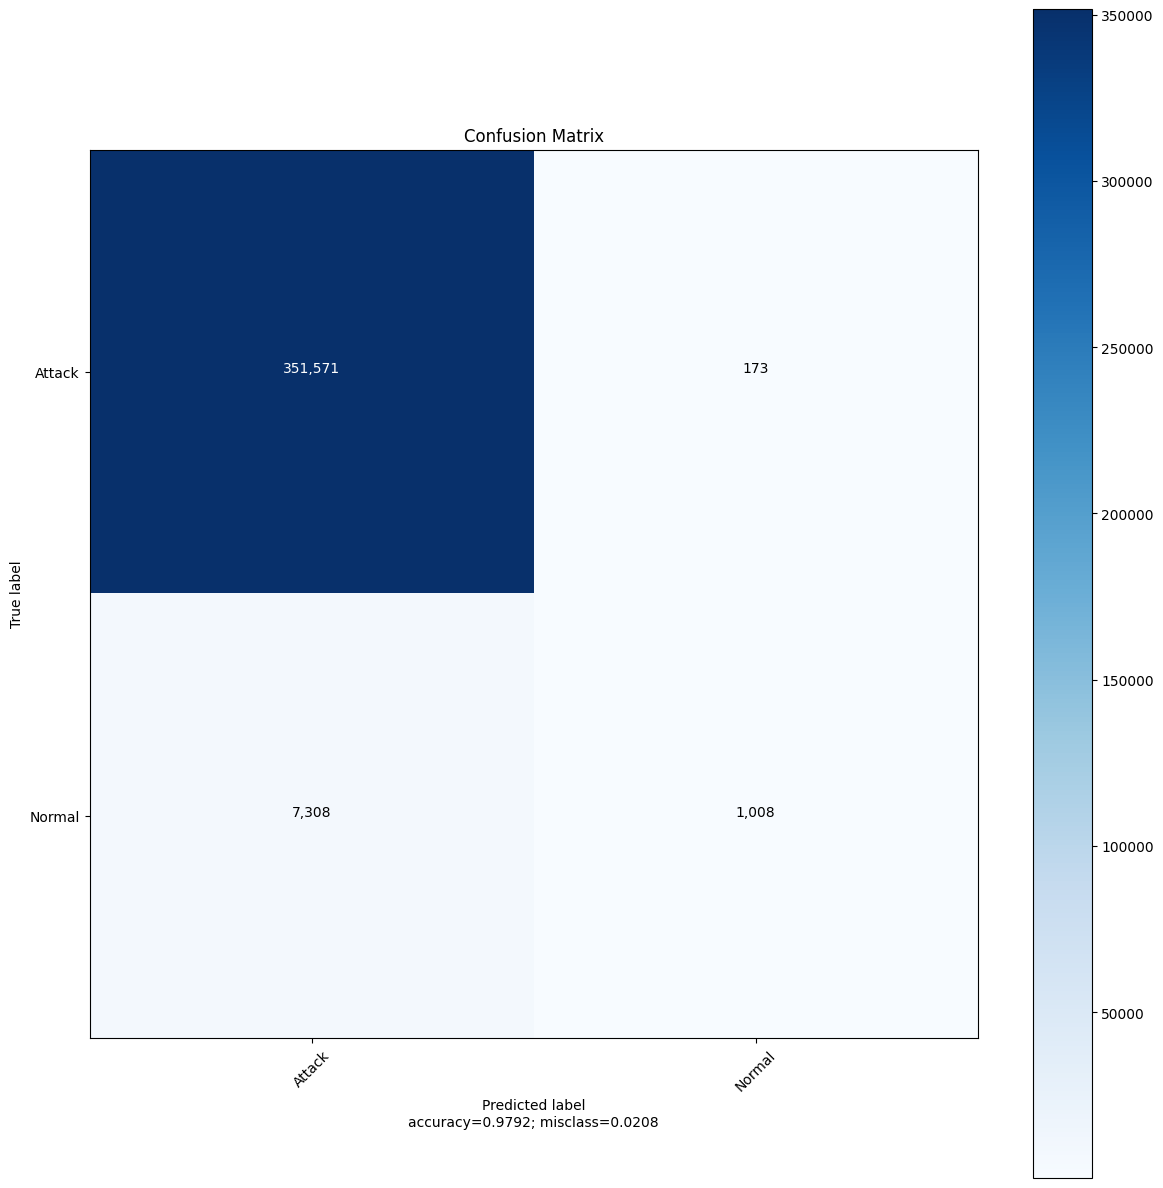

In [22]:
from sklearn.metrics import confusion_matrix

EGScommon.plot_confusion_matrix(confusion_matrix(actual, test_pred), 
                      normalize=False,
                      target_names = np.unique(actual),
                      title='Confusion Matrix')